# EEG Alpha Decoding Across Time Windows with LDA

This script evaluates how classification accuracy of EEG data varies as a function of time integration using Linear Discriminant Analysis (LDA). It processes EEG signals filtered in the alpha band, integrates the signal over various time windows, and uses cross-validation to estimate decoding performance for each window.

---

## **1. Data Preprocessing**
- **Data Loading and Setup:**
  - Loads preprocessed EEG data for multiple subjects from `.npz` files.
  - Retrieves EEG trial data (`X`), condition labels (`y`), and the sampling frequency (`fs`).

- **Channel Selection and Cleaning:**
  - Focuses on a subset of channels (`O1`, `O2`, `P3`, `P4`, `P7`, `P8`).
  - Removes subject-specific noisy channels based on a rejection list.

- **Signal Filtering:**
  - Applies a bandpass filter (8-12 Hz) to extract the alpha frequency band.
  - Removes filter edge artifacts by cropping the beginning and end of the signal.

- **Feature Extraction:**
  - Computes the log-transformed mean amplitude from the Hilbert transform for quantifying alpha power.

---

## **2. Time-Window Integration & Decoding**
- **Time Window Variation:**
  - Considers multiple integration durations, defined by `amount_integrated_time`, which linearly ranges from 5 to 80 (interpreted in 16 units of 30ms steps).
  - For each window size, selects the corresponding subset of time samples from the filtered data.

- **Classification with LDA:**
  - For each integration window, extracts features (log-Hilbert amplitude) and performs 4-fold cross-validation:
    - Splits the data into training and testing sets.
    - Trains an LDA classifier with Ledoit-Wolf covariance regularization.
    - Computes classification accuracy for each fold.
  - Aggregates fold accuracies to determine the mean accuracy per subject for the given integration window.

---

## **3. Group-Level Analysis & Results Saving**
- **Accuracies Accumulation:**
  - Stores mean accuracies for each subject and integration window in a dictionary.
  - Computes group-level mean accuracy and standard error (SE) across subjects for each window size.

- **Output:**
  - Compiles results into a structured NumPy array that contains:
    - Time window size.
    - Mean accuracy.
    - Standard error.
  - Saves the results array to a file in the designated decoding results directory.

---

## **4. Purpose and Applications**
- **Objective:**  
  To investigate the impact of varying time window integration on the decoding performance of EEG alpha power, thereby providing insights into the temporal dynamics relevant for distinguishing task conditions.



In [1]:
import os
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import accuracy_score
from sklearn.covariance import OAS
from scipy.signal import butter, sosfilt, hilbert
from os.path import join

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")


In [2]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the data.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)

def compute_average_hilbert_amplitude(data):
    """
    Compute log-mean amplitude using the Hilbert transform.
    """
    analytic = hilbert(data, axis=2)
    amplitude = np.abs(analytic)
    mean_amplitude = amplitude.mean(axis=2)  # avg across time
    return np.log(mean_amplitude)


In [3]:
picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]

subjects_channel_reject = {
    "VPpdib": ["CP2"],
    "VPpdih": ["C3"],
    "VPpdizb": ["Fz"],
    "VPpdizc": ["FC2"]
}

subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih", "VPpdii", "VPpdij",
    "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
    "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
]

In [4]:
task = "covert"
# Channels to extract features
selected_channels = ['P3', 'P4',  "O1", "O2", "P7", "P8"]

# Amount of integrated time
amount_integrated_time = np.linspace(5, 80, 16, dtype=int)

results_decoding = {
    "subjects": {},       # Holds per-subject accuracies for each time window
    "mean_accuracies": {}, # Group-level mean accuracies
    "se_accuracies": {}   # Group-level standard errors
}

group_accuracies_per_window = {}

for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Make a copy of picks and remove subject-specific bad channels
    picks_clean = picks_hubner.copy()
    if subject in subjects_channel_reject:
        channels_to_reject = subjects_channel_reject[subject]
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)

    # Load the data from the NPZ file
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs'].flatten()[0]  # sampling frequency

    # Select only a subset of channels
    n_channels = len(selected_channels)
    selected_indices = [picks_clean.index(ch) for ch in selected_channels if ch in picks_clean]
    data = X[:, selected_indices, :]

    # Bandpass filter around alpha band (8-12 Hz) and remove edges
    data = bandpass_filter(data, lowcut=8, highcut=14, fs=fs)
    data = data[:, :, 120:-120]  # remove edges to avoid filter artifacts

    # Initialize dictionary for storing subject-specific results
    results_decoding["subjects"][subject] = {}

    # Loop over time windows
    for window in amount_integrated_time:
        # Select data within the current time window
        window_data = data[:, :, :int(30 * window)]
        X_window = compute_average_hilbert_amplitude(window_data)

        # Cross-validation loop
        fold_accuracies = []
        n_folds = 4
        n_trials = X_window.shape[0] // n_folds
        folds = np.repeat(np.arange(n_folds), n_trials)

        for i_fold in range(n_folds):
            # Train / Test split
            X_trn, y_trn = X_window[folds != i_fold], y[folds != i_fold]
            X_tst, y_tst = X_window[folds == i_fold], y[folds == i_fold]

            # LDA with LedoitWolf
            lda = LDA(solver="lsqr", covariance_estimator=OAS())
            lda.fit(X_trn, y_trn)
            y_pred = lda.predict(X_tst)

            # Compute accuracy
            accuracy = accuracy_score(y_tst, y_pred)
            fold_accuracies.append(accuracy)

        subject_mean_accuracy = np.mean(fold_accuracies)

        # Log subject-specific accuracy for the current window
        if window not in results_decoding["subjects"][subject]:
            results_decoding["subjects"][subject][window] = []
        results_decoding["subjects"][subject][window].append(subject_mean_accuracy)

        # Accumulate these accuracies for the group
        if window not in group_accuracies_per_window:
            group_accuracies_per_window[window] = []
        group_accuracies_per_window[window].append(subject_mean_accuracy)

# Compute group-level mean and standard error for each time window
for window in sorted(group_accuracies_per_window.keys()):
    subject_accuracies = group_accuracies_per_window[window]

    # Group-level mean accuracy
    mean_accuracy = np.mean(subject_accuracies)

    # Standard error across subjects
    n_subjects = len(subject_accuracies)
    se_accuracy = np.std(subject_accuracies) / np.sqrt(n_subjects)

    # Log group-level results
    results_decoding["mean_accuracies"][window] = mean_accuracy
    results_decoding["se_accuracies"][window] = se_accuracy

# Convert group-level results to a structured NumPy array for saving
results_list = [
    (window, results_decoding["mean_accuracies"][window], results_decoding["se_accuracies"][window])
    for window in sorted(results_decoding["mean_accuracies"].keys())
]

results_array = np.array(
    results_list,
    dtype=[
        ('time_window', '<i4'),
        ('mean_accuracy', '<f4'),
        ('standard_error', '<f4'),
    ]
)

np.save(join(decoding_results_dir, f'{task}_lda_alpha_{n_channels}-ch_subset_decC_results.npy'), results_array)

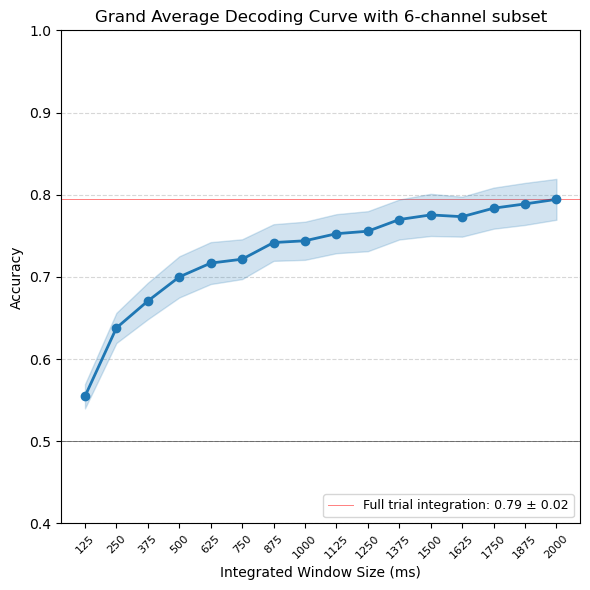

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

# Extract data from the structured array
time_windows   = results_array['time_window']
mean_accuracies = results_array['mean_accuracy']
mean_ses       = results_array['standard_error']

# Sort by time_window
sort_idx = np.argsort(time_windows)
time_windows   = time_windows[sort_idx] / 120 * 100   # convert from samples to miliseconds, 120 Hz sampling rate
mean_accuracies = mean_accuracies[sort_idx]
mean_ses       = mean_ses[sort_idx]

# Inter-stimulus interval 
isi = 30

# Create the figure
plt.figure(figsize=(6, 6))

# Plot decoding accuracy.
x_values = time_windows * isi  

plt.plot(x_values, mean_accuracies, color='tab:blue', lw=2)
plt.scatter(x_values, mean_accuracies, color='tab:blue', zorder=3)

# Shaded area for standard error
plt.fill_between(x_values, 
                 mean_accuracies - mean_ses, 
                 mean_accuracies + mean_ses, 
                 color='tab:blue', alpha=0.2, zorder=3)

# Customize the plot
plt.title(f'Grand Average Decoding Curve with {n_channels}-channel subset', fontsize=12)
plt.xlabel('Integrated Window Size (ms)', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.ylim(0.4, 1.0)
plt.yticks(np.arange(0.4, 1.1, 0.1))

# Set xticks to go from 1 to 20 seconds
plt.xticks(x_values, fontsize=8, rotation=45)

# Add reference lines
plt.axhline(0.5, color='k', linestyle='-', alpha=0.5, linewidth=0.7, label='')
plt.axhline(mean_accuracies[-1], color='red', linestyle='-', linewidth=0.7, 
            label=f'Full trial integration: {mean_accuracies[-1]:.2f} ± {mean_ses[-1]:.2f}', alpha=0.5)

# Add legend and grid
plt.legend(fontsize=9, loc='lower right')
plt.grid(alpha=0.5, linestyle='--', axis = 'y')
plt.tight_layout()


# Save the plot
plt.savefig(join(plots_dir, f'{task}_lda_alpha_{n_channels}-ch_subset_decC_results.png'), dpi=300)
plt.savefig(join(plots_dir, f'{task}_lda_alpha_{n_channels}-ch_subset_decC_results.png'), dpi=300)
plt.show()
